# Retrieval-Augmented Generation (RAG)

* RAG, or Retrieval-Augmented Generation pipeline, is a method in Artificial Intelligence that combines two steps: retrieving information and generating responses. In simple terms, it first searches a knowledge source to find relevant information based on the users’ questions.

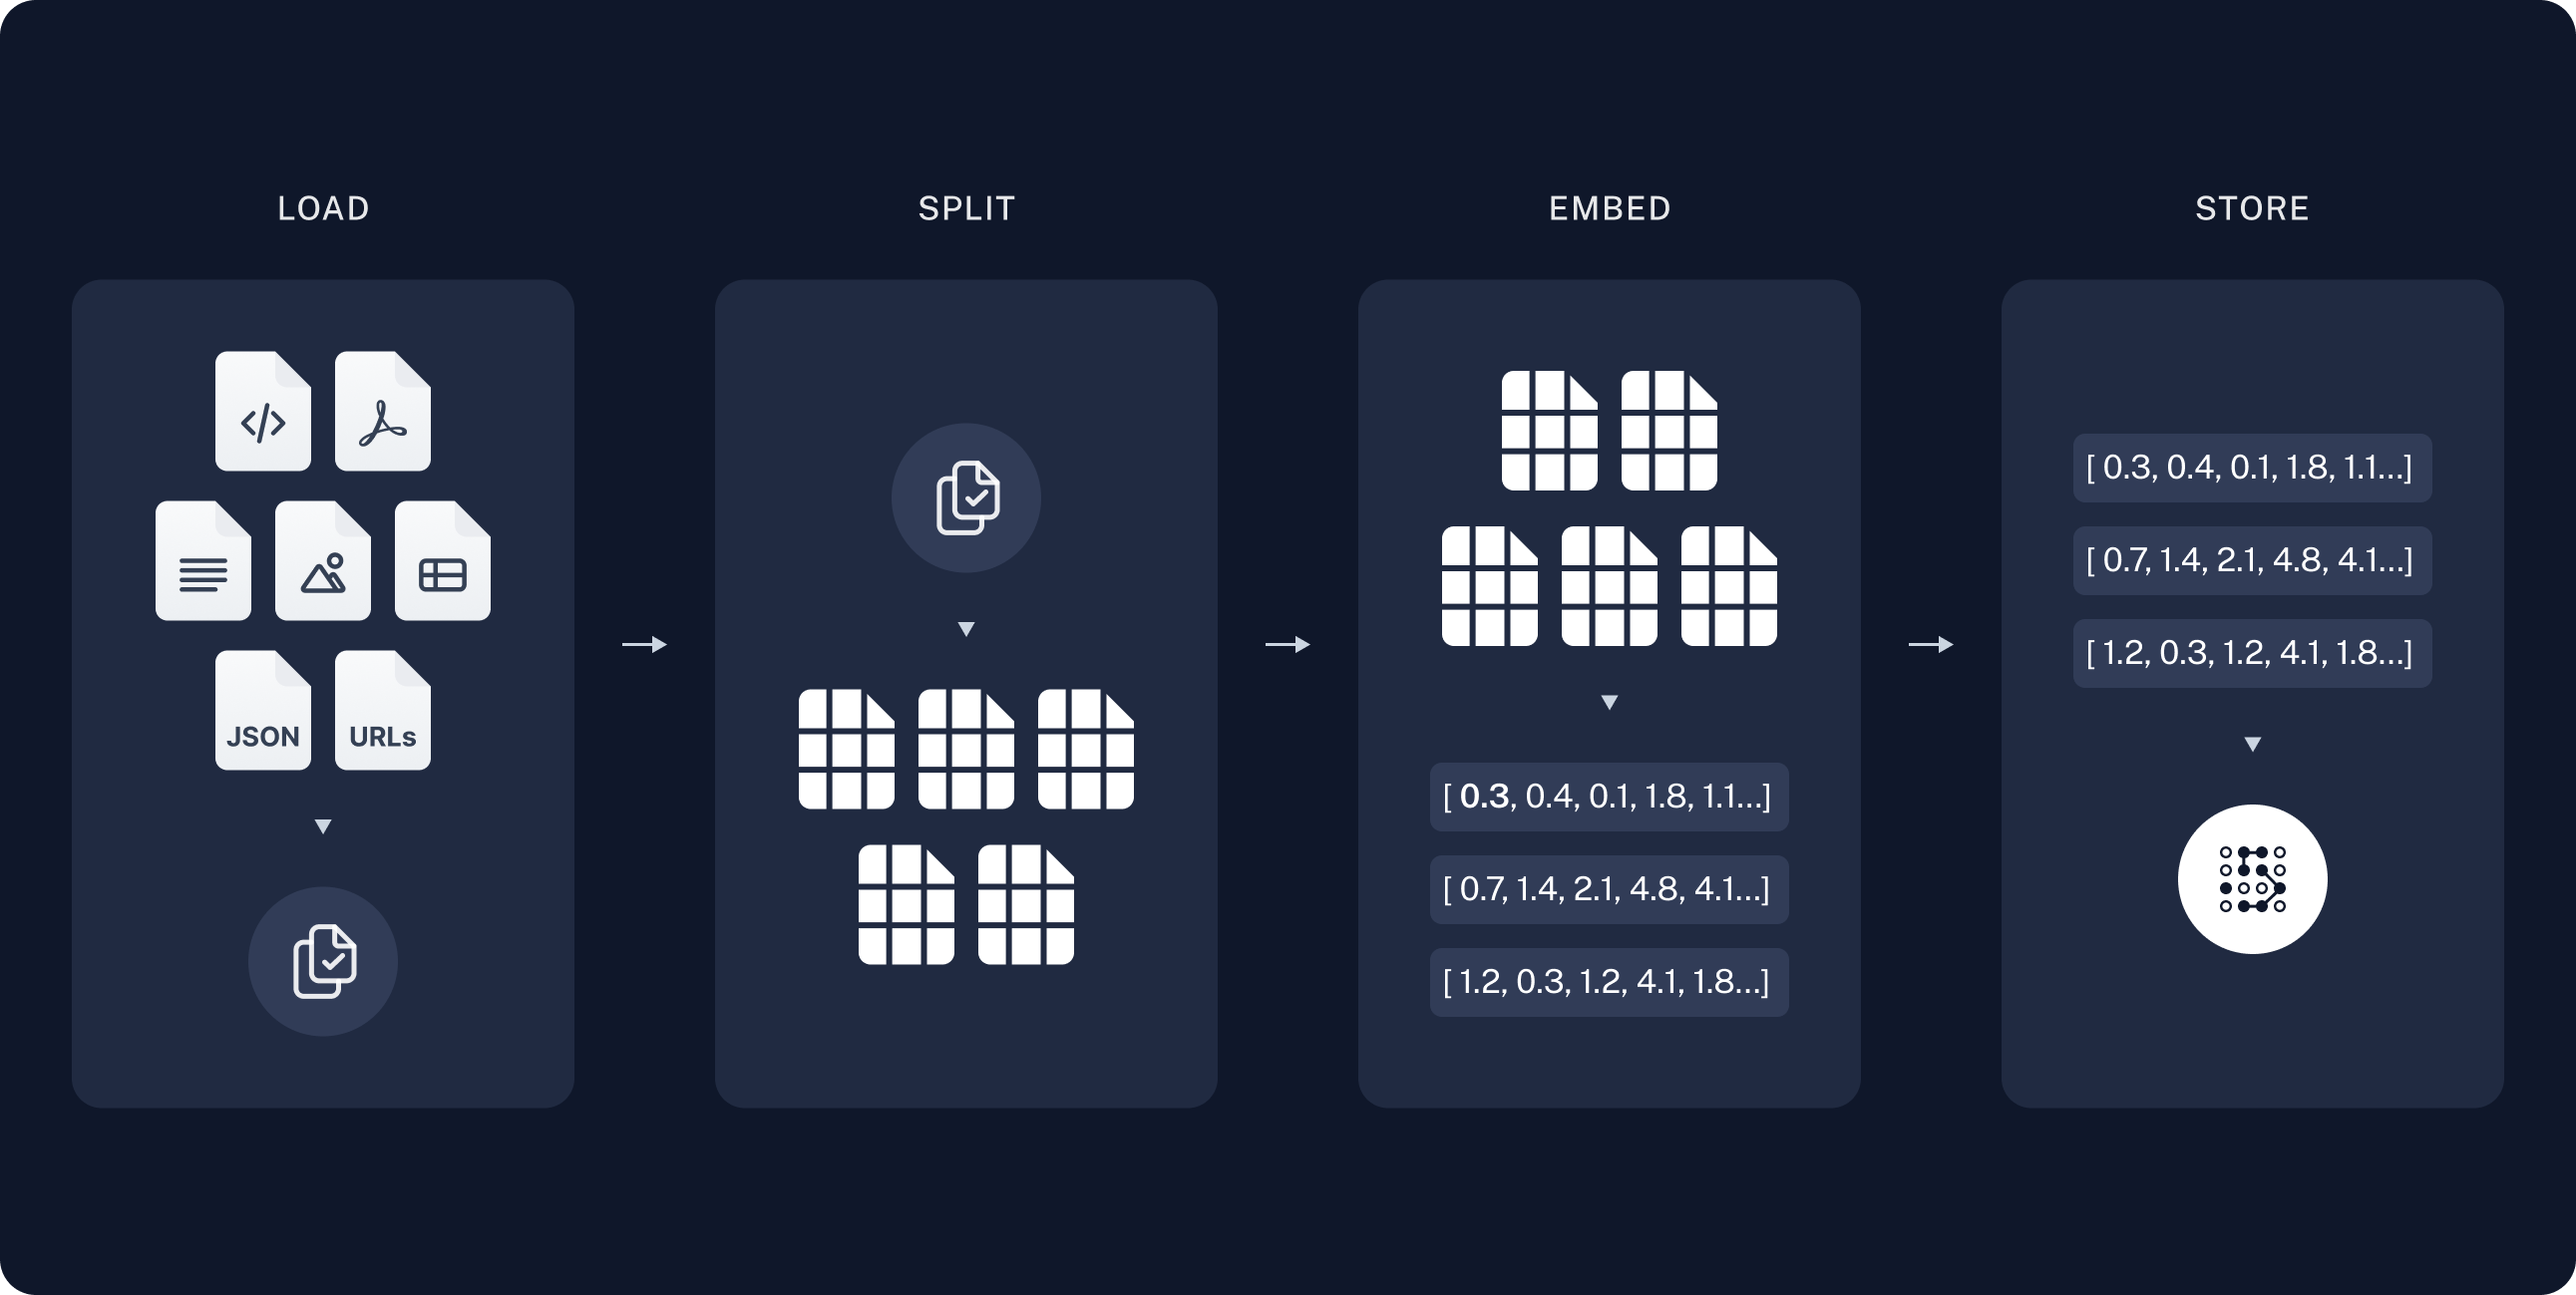

* Then, it uses LLM like GPT and more to create a detailed and context-aware response. This approach helps the AI to provide accurate and informed answers, especially for complex or specific queries.

### Step-1: Text Loader (Data ingestion)

#### 1. Text File

In [14]:
from langchain_community.document_loaders import TextLoader

text_file = TextLoader("../resources/example.txt")
docs = text_file.load()
docs

[Document(metadata={'source': '../resources/example.txt'}, page_content='The three prompts use the information provided by DR-Minerva, which consists in the scanning modality and the body part shown in the input image. Prompts were designed to provide more and more information to the Knowledge Graph, as their complexity increases. The maximum complexity will be reached in the last prompt, where we want to emulate the query that a doctor might pose to a diagnostic support system. In this case, information concerning the patient’s clinical history is used in addition to the information extrapolated from the images supplied to the multimodal system.\n\nThe generation of correct clinical text to support a doctor in the diagnostic process is a very different task. In this case, the same meaning can be expressed in a variety of forms that depend on many factors: the available knowledge about the particular case when the diagnosis is formulated, the different clinical practices in writing med

#### 2. PDF File

In [78]:
from langchain_community.document_loaders import PyPDFLoader

loader = PyPDFLoader('../resources/attention.pdf')
docs = loader.load()
docs

[Document(metadata={'source': '../resources/attention.pdf', 'page': 0}, page_content='Provided proper attribution is provided, Google hereby grants permission to\nreproduce the tables and figures in this paper solely for use in journalistic or\nscholarly works.\nAttention Is All You Need\nAshish Vaswani∗\nGoogle Brain\navaswani@google.com\nNoam Shazeer∗\nGoogle Brain\nnoam@google.com\nNiki Parmar∗\nGoogle Research\nnikip@google.com\nJakob Uszkoreit∗\nGoogle Research\nusz@google.com\nLlion Jones∗\nGoogle Research\nllion@google.com\nAidan N. Gomez∗ †\nUniversity of Toronto\naidan@cs.toronto.edu\nŁukasz Kaiser∗\nGoogle Brain\nlukaszkaiser@google.com\nIllia Polosukhin∗ ‡\nillia.polosukhin@gmail.com\nAbstract\nThe dominant sequence transduction models are based on complex recurrent or\nconvolutional neural networks that include an encoder and a decoder. The best\nperforming models also connect the encoder and decoder through an attention\nmechanism. We propose a new simple network architect

#### 3. Web Source

In [77]:
from langchain_community.document_loaders import WebBaseLoader
import bs4

## load,chunk and index the content of the html page
loader = WebBaseLoader(web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",), bs_kwargs=dict(parse_only=bs4.SoupStrainer(class_=("post-title","post-content","post-header"))))

docs=loader.load()
docs

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='\n\n      LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng\n\n\nBuilding agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview#\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistake

## Step-2: Text Splitter (or chunks)

Chunking or splitting large documents into manageable sections helps the RAG pipeline efficiently process and retrieve relevant information by enabling more precise retrieval and generation.

In [95]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1500,chunk_overlap=100)

documents = text_splitter.split_documents(docs)
documents[:5]

[Document(metadata={'source': '../resources/attention.pdf', 'page': 0}, page_content='Provided proper attribution is provided, Google hereby grants permission to\nreproduce the tables and figures in this paper solely for use in journalistic or\nscholarly works.\nAttention Is All You Need\nAshish Vaswani∗\nGoogle Brain\navaswani@google.com\nNoam Shazeer∗\nGoogle Brain\nnoam@google.com\nNiki Parmar∗\nGoogle Research\nnikip@google.com\nJakob Uszkoreit∗\nGoogle Research\nusz@google.com\nLlion Jones∗\nGoogle Research\nllion@google.com\nAidan N. Gomez∗ †\nUniversity of Toronto\naidan@cs.toronto.edu\nŁukasz Kaiser∗\nGoogle Brain\nlukaszkaiser@google.com\nIllia Polosukhin∗ ‡\nillia.polosukhin@gmail.com\nAbstract\nThe dominant sequence transduction models are based on complex recurrent or\nconvolutional neural networks that include an encoder and a decoder. The best\nperforming models also connect the encoder and decoder through an attention\nmechanism. We propose a new simple network architect

In [96]:
len(documents)

36

## Step-3: OpenAI Vector Embedding

It generates query embeddings from the input query, transforming the text into a dense vector representation that can be used to find relevant data in vector stores.

#### 1. OpenAI

In [81]:
from langchain_openai import OpenAIEmbeddings

embedding = OpenAIEmbeddings()

In [48]:
embedding

OpenAIEmbeddings(client=<openai.resources.embeddings.Embeddings object at 0x122ab5840>, async_client=<openai.resources.embeddings.AsyncEmbeddings object at 0x122d89300>, model='text-embedding-ada-002', dimensions=None, deployment='text-embedding-ada-002', openai_api_version=None, openai_api_base=None, openai_api_type=None, openai_proxy=None, embedding_ctx_length=8191, openai_api_key=SecretStr('**********'), openai_organization=None, allowed_special=None, disallowed_special=None, chunk_size=1000, max_retries=2, request_timeout=None, headers=None, tiktoken_enabled=True, tiktoken_model_name=None, show_progress_bar=False, model_kwargs={}, skip_empty=False, default_headers=None, default_query=None, retry_min_seconds=4, retry_max_seconds=20, http_client=None, http_async_client=None, check_embedding_ctx_length=True)

In [45]:
embedding_output = embedding.embed_query("Hello World")

In [47]:
len(embedding_output)

1536

In [49]:
print(embedding_output)

[-0.007019899319857359, 0.0034685435239225626, -0.00714093167334795, -0.029149780049920082, -0.013071536086499691, 0.010905686765909195, -0.02034624107182026, 0.005309515167027712, -0.008523252792656422, -0.03011804260313511, 0.024333951994776726, 0.009733580984175205, -0.027544504031538963, -0.006656800862401724, 0.009134787134826183, 0.0154412304982543, 0.021926037967205048, -0.009650768712162971, 0.010982128791511059, 0.015938101336359978, -0.005828682333230972, 0.007007158827036619, 0.005105670541524887, 0.0047362023033201694, -0.014014317654073238, -0.006242741364985704, 0.005529285408556461, -0.025378655642271042, 0.0308824609965086, -0.030245445668697357, 0.009860983118414879, -0.012256157584488392, -0.0024556906428188086, -0.027977673336863518, 0.007758835796266794, -0.012606515549123287, -0.00264201732352376, -0.01499531976878643, 0.0187282245606184, -0.01942894048988819, 0.005045154597610235, 0.014154461212456226, 0.007446698844432831, -0.019377978518605232, -0.03694683685898

### 2. Google

In [57]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings

embedding = GoogleGenerativeAIEmbeddings(model="models/embedding-001")

In [59]:
embedding_output = embedding.embed_query("Hello World")

In [60]:
len(embedding_output)

768

In [61]:
print(embedding_output)

[0.04656680300831795, -0.0376756377518177, -0.0274836253374815, -0.02519204653799534, 0.023942284286022186, -0.0026659469585865736, 0.03314977511763573, -0.01167928334325552, 0.01575605198740959, 0.011231985874474049, 0.04642638564109802, 0.05251286178827286, -0.016256840899586678, -0.070755735039711, 0.007036404684185982, -0.016928454861044884, 0.012160800397396088, -0.014925220981240273, 0.004741536919027567, -0.006181327160447836, 0.007728793192654848, 0.007614525035023689, -0.027439264580607414, -0.027118556201457977, 0.009740605019032955, 0.01122963149100542, 0.005851471330970526, -0.07603289186954498, 0.003776128403842449, 0.06842293590307236, -0.04293884336948395, 0.0112407635897398, -0.06690558791160583, 0.01637372560799122, 0.04713474214076996, -0.05254290625452995, 0.033385295420885086, 0.022396456450223923, -0.006627627648413181, -0.0022224157582968473, 0.006207042373716831, -0.08901160955429077, -0.03087202087044716, -0.03697224333882332, 0.05005444958806038, -0.00601725187

#### 3. Meta AI

In [63]:
from langchain_ollama import OllamaEmbeddings

embeddings = OllamaEmbeddings(model="llama3.2")

In [67]:
embedding_output = embeddings.embed_query("Hello World")

In [68]:
len(embedding_output)

3072

In [69]:
print(embedding_output)

[-0.007954462, 0.008476641, 0.05463408, -0.01476738, 0.0072562844, 0.016631367, 0.016746694, -0.0015238654, -0.004205094, -0.01040362, -0.021913826, 0.005261734, 0.02215019, 0.012887883, -0.0195968, 0.0060793376, -0.0033728373, 0.001543817, -0.035377424, -0.023357397, -0.023822151, -0.006485235, 0.015539228, 0.00394657, 0.004263525, -0.015125035, 0.01723131, -0.018437413, 0.023629542, -0.009872443, 0.009542378, 0.007180848, -0.008266936, 0.008872313, 0.017730905, 0.0012160616, 0.008180452, 0.041505657, -0.016986856, -0.017523762, -0.0011449611, -0.007916734, 0.0040017525, -0.00088952994, -0.005743914, -0.0071299355, 0.011209025, 0.006413733, -0.014528984, -0.007316766, 0.011989915, 0.00252694, -0.0046933615, 0.0074815094, -0.0073904917, 0.023839492, 0.020927457, -0.026161892, -0.012528157, 0.0019315662, 0.004260346, 0.04247243, -0.005321, -0.0028548897, 0.040867753, -0.043278355, 0.0007576212, -0.002788089, -0.009446117, -0.018988678, -0.0057977512, 0.014433908, 0.022601767, 0.00191934

## Step-4: Vector Stores Databses

This component stores and organizes embeddings for quick access and retrieval based on similarity scores. When a query is processed, vector stores help locate the most relevant documents or passages.

### 1. Chroma

In [97]:
from langchain_community.vectorstores import Chroma

db = Chroma.from_documents(documents, OpenAIEmbeddings())

In [98]:
query = "Who are the authors of attention is all you need?"
retireved_results = db.similarity_search(query)

print(retireved_results[0].page_content)

Attention Is All


### 2. FAISS

In [91]:
from langchain_community.vectorstores import FAISS

db = FAISS.from_documents(documents[:15], GoogleGenerativeAIEmbeddings(model="models/embedding-001"))

In [92]:
query = "Who are the authors of attention is all you need?"
retireved_results = db.similarity_search(query)

print(retireved_results[0].page_content)

Provided proper attribution is provided, Google hereby grants permission to
reproduce the tables and figures in this paper solely for use in journalistic or
scholarly works.
Attention Is All You Need
Ashish Vaswani∗
Google Brain
avaswani@google.com
Noam Shazeer∗
Google Brain
noam@google.com
Niki Parmar∗
Google Research
nikip@google.com
Jakob Uszkoreit∗
Google Research
usz@google.com
Llion Jones∗
Google Research
llion@google.com
Aidan N. Gomez∗ †
University of Toronto
aidan@cs.toronto.edu
Łukasz Kaiser∗
Google Brain
lukaszkaiser@google.com
Illia Polosukhin∗ ‡
illia.polosukhin@gmail.com
Abstract
The dominant sequence transduction models are based on complex recurrent or
convolutional neural networks that include an encoder and a decoder. The best
performing models also connect the encoder and decoder through an attention
mechanism. We propose a new simple network architecture, the Transformer,
based solely on attention mechanisms, dispensing with recurrence and convolutions
entirely. Exp